# 1. Process Data

## 1.1 load train dataset

In [3]:
import io
import copy
import torch
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

In [4]:
# read data by lines (cannot directly read by pd.read_csv())
# save each data point into lists

def load_dataset(path):
    i = 0
    user_id, user_click_history, user_protrait, exposed_items, labels, time = [], [], [], [], [], []
    with io.open(path,'r') as file:
        for line in file:
            if i > 0:
                user_id_1, user_click_history_1, user_protrait_1, exposed_items_1, labels_1, time_1 = line.split(' ')
                user_id.append(user_id_1)
                user_click_history.append(user_click_history_1)
                user_protrait.append(user_protrait_1)
                exposed_items.append(exposed_items_1)
                labels.append(labels_1)
                time.append(time_1)
            i = i + 1
    return user_id, user_click_history, user_protrait, exposed_items, labels, time

In [5]:
user_id, user_click_history, user_protrait, exposed_items, labels, time = load_dataset("./data/trainset.csv")

In [6]:
train_set = pd.DataFrame({
    "user_id": user_id,
    "user_click_history": user_click_history,
    "user_protrait": user_protrait,
    "exposed_items": exposed_items,
    "labels": labels,
    "time": time,
})

In [7]:
train_set.head()

,user_id,user_click_history,user_protrait,exposed_items,labels,time
0,1,"30:1580603130,34:1581178937,15:1581178939,28:1...","64054,21804,80911,36504,8867,7615,54240,37294,...","1,20,28,99,86,119,213,237,164","1,1,1,1,1,1,1,1,1",1582992009\n
1,2,"20:1580644762,13:1580644765,1:1580644770,127:1...","64054,26565,93755,88510,6344,7615,54240,21927,...","1,4,26,112,86,117,191,234,172","1,1,1,1,1,1,1,1,0",1582992010\n
2,3,"39:1580772975,6:1580772981,1:1581178309,2:1581...","64054,64086,63021,88510,93500,7615,54240,21927...","22,4,28,48,105,42,193,236,159","1,1,1,0,1,0,0,0,0",1582992014\n
3,4,"6:1580657608,9:1580657612,15:1580657615,127:15...","64054,21531,6599,16721,37078,7615,54240,65505,...","5,16,1,74,133,122,235,218,172","1,1,1,1,1,1,1,1,0",1582992014\n
4,5,"37:1580743545,36:1580743554,25:1580743556,37:1...","64054,66036,6599,88510,76066,20543,83978,37294...","6,1,16,85,73,112,239,172,205","1,1,1,1,1,1,1,1,1",1582992017\n


Description of data:

**user_id**: the unique identifier of the user

**user_click_history**: the user's click history features. Data format: itemid1:timestamp1,itemid2:timestamp2,....

**user_protrait**: the user's portrait features. Data format: feature1,feature2,....

**exposed_items**: a nine-length vector composed of the unique identifier of the nine items

**labels**: a nine-length 0/1 vector to indicate user purchase or not

**time**: timestamp when the event happens

## 1.2 Load item info

In [57]:
def load_item_info(path='./data/item_info.csv'):
    
    item_id, item_vec, price, location = [], [], [], []
    i = 0
    with io.open(path,'r') as file:
        for line in file:
            if i > 0:
                
                item_vec_row = []
                item_id_1, item_vec_1, price_1, location_1 = line.split(' ')
                
                item_id_1 = float(item_id_1)
                price_1 = float(price_1)
                location_1 = float(location_1)
                
                item_vec_list = item_vec_1.split(',')
                for item_2 in item_vec_list:
                    item_vec_row.append(float(item_2))

                item_id.append(item_id_1)
                item_vec.append(item_vec_row)
                price.append(price_1)
                location.append(location_1)
                    
            i = i + 1
            
    return item_id, item_vec, price, location
    
def load_item_info2():
    price_max = 150.0
    price_min = 16621.0
    item_info_list = []
    item_id, item_vec, price, location = [], [], [], []
    i = 0
    with io.open('./data/item_info.csv','r') as file:
        for line in file:
            if i > 0:
                item_info = {}
                item_vec_row = []

                item_id_1, item_vec_1, price_1, location_1 = line.split(' ')
                item_id_1 = float(item_id_1)
                price_1 = float(price_1)
                price_1 = (price_1 - price_min) / (price_max - price_min)
                location_1 = float(location_1)

                item_vec_list = item_vec_1.split(',')
                for item_2 in item_vec_list:
                    item_vec_row.append(float(item_2))

                item_id.append(item_id_1)
                item_vec.append(item_vec_row)
                price.append(price_1)
                location.append(location_1)

                item = []
                for j in range(len(item_vec_row)):
                    item.append(item_vec_row[j])
                item.append(price_1)
                item.append(location_1)
                item_info[item_id_1] = item
                
                item_info_list.insert(int(item_id_1)-1, item_info)

            i = i + 1
    return item_info_list

def reformat_item_info_for_test(item_id, item_vec, price, location):
    
    # reformat data
    item_info_list = []
    price_min = min(price)
    price_max = max(price)

    for i in range(len(item_id)):
        item_id_i = item_id[i]
        item_vec_row = item_vec[i]
        item_info = {}
        item = []
        
        # normalize price
        price_i = price[i]
        price_i = (price_i - price_min) / (price_max - price_min)
        
        # expand item vector
        for j in range(len(item_vec_row)):
            item.append(item_vec_row[j])
            
        # add price, location, item id into item_info
        item.append(price_i)
        item.append(location[i])
        item_info[item_id_i] = item

        item_info_list.insert(int(item_id_i)-1, item_info)

    return item_info_list

In [9]:
item_id, item_vec, price, location = load_item_info(path='./data/item_info.csv')

In [10]:
item_info_list = reformat_item_info(item_id, item_vec, price, location)

Text(0, 0.5, 'Count')

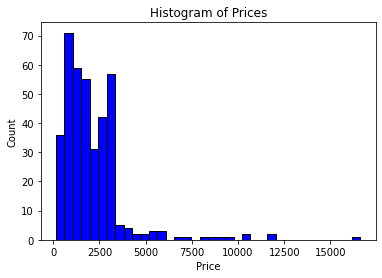

In [11]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(price, color = 'blue', edgecolor = 'black',
         bins = int(180/5))
# Add labels
plt.title('Histogram of Prices')
plt.xlabel('Price')
plt.ylabel('Count')



Text(0, 0.5, 'Count')

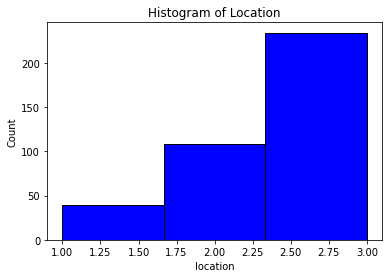

In [12]:
# matplotlib histogram
plt.hist(location, color = 'blue', edgecolor = 'black',
         bins = 3)
# Add labels
plt.title('Histogram of Location')
plt.xlabel('location')
plt.ylabel('Count')

## 1.3 Data Preprocessing

In [13]:
def data_processing(user_click_history, user_protrait, exposed_items, labels, item_info_list):
    
    user_click_history_processed, user_click_history_avg_processed = process_click_history(user_click_history, item_info_list)
    user_protrait_processed = process_user_protrait(user_protrait)
    exposed_items_id, exposed_items_processed = process_exposed_items(exposed_items, item_info_list)
    labels_processed = process_labels(labels)
    
    # normalize click history and protrait 
    scaler = StandardScaler()
    user_click_history_processed = scaler.fit_transform(user_click_history_processed).tolist()
    user_protrait_processed = scaler.fit_transform(user_protrait_processed).tolist()
    
    return user_click_history_processed, user_click_history_avg_processed, user_protrait_processed, exposed_items_processed, labels_processed, exposed_items_id


In [14]:
def process_click_history(use_click_history, item_info_list):

    
    user_click_history_processed = []
    user_click_history_avg_processed = []
    
    count = 0
    for item in user_click_history:
        count +=1 
        user_click_history_row = []
        user_click_history_row_avg = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        item_split_list = item.split(',')
        for item_2 in item_split_list:
            click_history = float(item_2.split(':')[0])
            user_click_history_row.append(click_history)
            
            if click_history == 0.0:
                continue

            item_info_dic = item_info_list[int(click_history)-1]
            item_info = item_info_dic[float(click_history)]
            user_click_history_row_avg = user_click_history_row_avg + np.array(item_info)

        # append user_click_history_row

        for i in range(249-len(user_click_history_row)):
            user_click_history_row.append(0.0)
        
        user_click_history_processed.append(user_click_history_row)
        user_click_history_row_avg = user_click_history_row_avg / len(item_split_list)
        user_click_history_row_avg = user_click_history_row_avg.tolist()
        user_click_history_avg_processed.append(user_click_history_row_avg)

    return user_click_history_processed, user_click_history_avg_processed


In [15]:
def process_user_protrait(user_protrait):
    
    user_protrait_processed = []
    for item in user_protrait:
        user_protrait_row = []
        item_split_list = item.split(',')
        for item_2 in item_split_list:
            user_protrait_row.append(float(item_2))
        user_protrait_processed.append(user_protrait_row)

    return user_protrait_processed

In [16]:
def process_exposed_items(exposed_items, item_info_list):
    
    exposed_items_id = []
    exposed_items_processed = []
    for item in exposed_items:
        exposed_items_id_row = []
        exposed_items_row = []
        item_split_list = item.split(',')
        
        for item_id in item_split_list:
            item_info_dic = item_info_list[int(item_id)-1]
            item_info = item_info_dic[float(item_id)]
            exposed_items_row.append(item_info)
            exposed_items_id_row.append(float(item_id))
            
        exposed_items_id.append(exposed_items_id_row)
        exposed_items_processed.append(exposed_items_row)
        
    return exposed_items_id, exposed_items_processed

In [17]:
def process_labels(labels):
    labels_processed = []
    for item in labels:
        labels_row = []
        item_split_list = item.split(',')
        for item_2 in item_split_list:
            labels_row.append(float(item_2))
        labels_processed.append(labels_row)
        
    return labels_processed

In [55]:
def data_track2_test_processing(user_click_history, user_protrait, item_info_list):
    user_click_history_processed = []
    for item in user_click_history:
        user_click_history_row = []
        item_split_list = item.split(',')
        for item_2 in item_split_list:
            click_history = float(item_2.split(':')[0])
            user_click_history_row.append(click_history)

        if len(user_click_history_row) < 249:
            for i in range(249-len(user_click_history_row)):
                user_click_history_row.append(0.0)
        
        if len(user_click_history_row) > 249:
            user_click_history_row = user_click_history_row[:249]

        user_click_history_processed.append(user_click_history_row)

    user_click_history_avg_processed = []
    for item in user_click_history:
        user_click_history_row_avg = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        item_split_list = item.split(',')
        for item_2 in item_split_list:
            click_history_item_id = float(item_2.split(':')[0])
            
            if click_history_item_id == 0.0:
                continue
            
#             if len(item_info_list) not in [1524 + i * 381 for i in range(100)]:
#                 print(len(item_info_list))
#                 print(int(click_history_item_id)-1)
#                 print("---")
            try:
                item_info_dic = item_info_list[int(click_history_item_id)-1]
                item_info = item_info_dic[float(click_history_item_id)]
                user_click_history_row_avg = user_click_history_row_avg + np.array(item_info)
            except:
                print(len(item_info_dic))
                print(float(click_history_item_id))
                print("---")
                
        user_click_history_row_avg = user_click_history_row_avg / len(item_split_list)
        user_click_history_row_avg = user_click_history_row_avg.tolist()

        user_click_history_avg_processed.append(user_click_history_row_avg)

    user_protrait_processed = []
    for item in user_protrait:
        user_protrait_row = []
        item_split_list = item.split(',')
        for item_2 in item_split_list:
            user_protrait_row.append(float(item_2))
        user_protrait_processed.append(user_protrait_row)

    return user_click_history_processed, user_click_history_avg_processed, user_protrait_processed

In [19]:
processed = data_processing(user_click_history, user_protrait, exposed_items, labels, item_info_list)
user_click_history_processed, user_click_history_avg_processed, user_protrait_processed, exposed_items_processed, labels_processed, exposed_items_id = processed


# 2. create data loader

In [20]:
class Dataset(torch.utils.data.Dataset):
    # Characterizes a dataset for PyTorch
    def __init__(self, user_click_history_processed, user_click_history_avg_processed,
                 user_protrait_processed, exposed_items_processed, labels_processed, exposed_items_id):
        # Initialization
        
        # random shuffle
        c = list(zip(user_click_history_processed, user_click_history_avg_processed,
                    user_protrait_processed, exposed_items_processed, labels_processed, exposed_items_id))              # 将a,b整体作为一个zip,每个元素一一对应后打乱
        random.shuffle(c)               # 打乱c
        user_click_history_processed[:], user_click_history_avg_processed[:], user_protrait_processed[:], \
                exposed_items_processed[:], labels_processed[:], exposed_items_id[:] = zip(*c)
        
        self.user_click_history = user_click_history_processed
        self.user_click_history_avg = user_click_history_avg_processed
        self.user_protrait = user_protrait_processed
        self.exposed_items = exposed_items_processed
        self.labels = labels_processed
        self.exposed_items_id = exposed_items_id

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        user_click_history = self.user_click_history[index]
        user_click_history_avg = self.user_click_history_avg[index]
        user_protrait = self.user_protrait[index]
        exposed_items = self.exposed_items[index]
        exposed_items_id = self.exposed_items_id[index]
        
        labels = self.labels[index]

        # Load data and get label
        X = user_click_history, user_click_history_avg, user_protrait, exposed_items, exposed_items_id
        y = labels

        return user_click_history, user_click_history_avg, user_protrait, exposed_items, exposed_items_id, labels

In [21]:
def collate_fn(data):
    user_click_history_processed_batch = []
    user_click_history_avg_processed_batch = []
    user_protrait_processed_batch = []
    exposed_item_batch = []
    labels_batch = []
    exposed_items_id_batch = []
    
    for user_click_history, user_click_history_avg, user_protrait, exposed_items, exposed_items_id, labels in data:
        
        user_click_history_processed_batch.append(user_click_history)
        user_click_history_avg_processed_batch.append(user_click_history_avg)
        user_protrait_processed_batch.append(user_protrait)
        exposed_item_batch.append(exposed_items)
        exposed_items_id_batch.append(exposed_items_id)
        labels_batch.append(labels)
        
    return user_click_history_processed_batch, user_click_history_avg_processed_batch, user_protrait_processed_batch, exposed_item_batch, exposed_items_id_batch, labels_batch
        

In [ ]:
# create dataset

train_dataset = Dataset(user_click_history_processed, user_click_history_avg_processed,
                 user_protrait_processed, exposed_items_processed, labels_processed, exposed_items_id)

In [ ]:
BATCH_SIZE = 2048

# create dataloader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# 3. Create Model

In [ ]:
class FullyConnectQ(nn.Module):
    def __init__(self, state_dim, num_actions):
        super(FullyConnectQ, self).__init__()
        self.q1 = nn.Linear(state_dim, 512)
        self.q2 = nn.Linear(512, 256)
        self.q3 = nn.Linear(256, num_actions)

        self.i1 = nn.Linear(state_dim, 512)
        self.i2 = nn.Linear(512, 256)
        self.i3 = nn.Linear(256, num_actions)

    def forward(self, state):
        
        q = F.relu(self.q2(F.relu(self.q1(state))))
        i = F.relu(self.i3(F.relu(self.i2(F.relu(self.i1(state))))))

        return self.q3(q), F.log_softmax(i, dim=1), i

In [ ]:
# policy

class BCQ(object):
    def __init__(
        self, num_actions=381, state_dim=273, polyak_target_update=True, ):

        self.device = 'cuda'

        # Determine network type
        self.Q = FullyConnectQ(state_dim, num_actions).to(self.device)
        self.Q_target = copy.deepcopy(self.Q)
        self.Q_optimizer = getattr(torch.optim, "Adam")(self.Q.parameters(), **{"lr": 3e-4})

        # Target update rule
        self.maybe_update_target = self.polyak_target_update if polyak_target_update else self.copy_target_update

        # Evaluation hyper-parameters
        self.state_shape =  (-1, state_dim)
        self.num_actions = num_actions

        # Number of training iterations
        self.iterations = 0


    def select_action(self, state, step, action_list, eval=False):
        mask_list = []
        if 0<=step and step<=2:
            mask_list += [a for a in range(39, 381)]
        elif 3<=step and step<=5:
            mask_list += [a for a in range(0, 39)] + [b for b in range(147, 381)]
        elif 6<=step and step<=8:
            mask_list += [a for a in range(0, 147)]
        action_list = (np.array(action_list) - 1).tolist()
        mask_list += action_list
        mask_list = list(set(mask_list))

        # Select action according to policy with probability (1-eps) otherwise, select random action
        if np.random.uniform(0, 1) > 0.001:  # set evaluate epos to 0.001
            with torch.no_grad():
                state = torch.FloatTensor(state).reshape(self.state_shape).to(self.device)
                q, imt, i = self.Q(state)
                # action mask
                for idx in range(q.shape[0]):
                    imt[idx][mask_list] += -1e10
                imt = imt.exp()
                imt = (imt/imt.max(1, keepdim=True)[0] > 0.3).float()  # set threshold to 0.3, Threshold for "unlikely" actions
                return int((imt * q + (1. - imt) * -1e8).argmax(1))
        else:
            return np.random.randint(self.num_actions)


    def train_batch(self, state, action, next_state, reward, done):
        for bth_idx in range(len(action)):
            action[bth_idx] = action[bth_idx] - 1.0

        state = torch.FloatTensor(state).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        action = torch.LongTensor(action).unsqueeze(1).to(self.device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(self.device)
        done = torch.FloatTensor(done).unsqueeze(1).to(self.device)

        # Compute the target Q value
        with torch.no_grad():
            q, imt, i = self.Q(next_state)
            imt = imt.exp()
            imt = (imt/imt.max(1, keepdim=True)[0] > 0.3).float()  # set threshold to 0.3

            # Use large negative number to mask actions from argmax
            next_action = (imt * q + (1 - imt) * -1e8).argmax(1, keepdim=True)

            q, imt, i = self.Q_target(next_state)
            target_Q = reward + (1.0 - done) * 0.99 * q.gather(1, next_action).reshape(-1, 1)  # set discount to 0.99

        # Get current Q estimate
        current_Q, imt, i = self.Q(state)
        current_Q = current_Q.gather(1, action)

        # Compute Q loss
        q_loss = F.smooth_l1_loss(current_Q, target_Q)
        i_loss = F.nll_loss(imt, action.reshape(-1))

        Q_loss = q_loss + i_loss + 1e-2 * i.pow(2).mean()

        # Optimize the Q
        self.Q_optimizer.zero_grad()
        Q_loss.backward()
        self.Q_optimizer.step()

        # Update target network by polyak or full copy every X iterations.
        self.iterations += 1
        self.maybe_update_target()

        return Q_loss

    # hard update: theta' = theta
    # soft update(or Polyak update): theta' = tau*theta + (1-tau)*theta', tau is a little value, such as 0.001
    # θ_target = τ*θ_local + (1 - τ)*θ_target
    def polyak_target_update(self):
        for param, target_param in zip(self.Q.parameters(), self.Q_target.parameters()):
            # target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            target_param.data.copy_(0.005 * param.data + (1 - 0.005) * target_param.data)

    # hard update: theta' = theta
    def copy_target_update(self):
        if self.iterations % 1000 == 0:  # set target_update_frequency to 1000
            self.Q_target.load_state_dict(self.Q.state_dict())

## Train Pipeline

In [ ]:
def concat_feature_batch(user_click_history_processed_batch, user_click_history_avg_processed_batch, user_protrait_processed_batch, exposed_item_feature_processed_batch):
    feature_batch = []
    for i in range(len(user_click_history_processed_batch)):
        feature_row = user_click_history_processed_batch[i] + user_click_history_avg_processed_batch[i] + user_protrait_processed_batch[i] + exposed_item_feature_processed_batch[i]
        feature_batch.append(feature_row)
    return feature_batch

In [64]:
def train_BCQ_batch(train_dataloader, state_dim, num_actions, epoch_num=100, batch_size=1024):
    print("epoch_num: ", epoch_num)
    print("batch_size: ", batch_size)

    # Initialize and load policy
    print("Initialize and load policy")
    policy = BCQ(num_actions=num_actions, state_dim=state_dim)
    # action_result_list = eval_policy(policy)
    
    print("Training  ...")
    batch_num = len(train_dataloader) - 1
    q_loss_list = []
    reward_list = []
    for epoch in range(epoch_num):
        q_loss_total = 0.0
        reward_total = 0.0
        
        count = 0
        
        for batch in tqdm(train_dataloader):
            count += 1
            if count < batch_num:
                user_click_history_processed_batch, user_click_history_avg_processed_batch, \
                    user_protrait_processed_batch, exposed_item_batch, exposed_items_id_batch, labels_batch = batch
    #                 print(len(exposed_item_batch))
                num_step = 9
                for step in range(num_step):
                    if step == 0:
                        exposed_item_feature_last_batch = []
                        for bth in range(batch_size):
                            exposed_item_feature_last_batch.append([0, 0, 0, 0, 0, 0, 0])
                    else:
                        exposed_item_feature_last_batch = []
                        for bth in range(batch_size):
                            exposed_item_feature_last_batch.append(exposed_item_batch[bth][step - 1])
                    exposed_item_feature_cur_batch = []

                    for bth in range(batch_size):
                        exposed_item_feature_cur_batch.append(exposed_item_batch[bth][step])

                    # state : user_click_history + user_protrait + last product features
                    state = concat_feature_batch(user_click_history_processed_batch, user_click_history_avg_processed_batch, user_protrait_processed_batch, exposed_item_feature_last_batch) #list 266

                    # next_state : user_click_history + user_protrait + current product features
                    next_state = concat_feature_batch(user_click_history_processed_batch, user_click_history_avg_processed_batch, user_protrait_processed_batch, exposed_item_feature_cur_batch)#list 266

                    # action
                    reward = []
                    action = []
                    for bth in range(batch_size):
                        if labels_batch[bth][step] == 1.0:
                            reward.append(labels_batch[bth][step] * exposed_item_feature_cur_batch[bth][-2])
                        else:
                            reward.append((-0.25) * exposed_item_feature_cur_batch[bth][-2])
                        action.append(exposed_items_id_batch[bth][step])

                    done = batch_size*[1.0] if (step == num_step-1) else batch_size*[0.0]
                    q_loss = policy.train_batch(state, action, next_state, reward, done)
                    q_loss_total += q_loss.item()
                    reward_total += sum(reward)

        print(f"At epoch {epoch}, the total loss is {q_loss_total}, the total reward is {reward_total}.")
        q_loss_list.append(q_loss_total)
        reward_list.append(reward_total)

        # evaluations
        if epoch > 0 and epoch % 1 == 0:
#             _ = eval_policy(policy)

            print("Predicting & write_csv  ...")
            action_result_list = eval_policy(policy)
            write_csv(action_result_list, epoch)
        

In [65]:
def eval_policy(policy):
    print("Evaluation Policy   ...")
    test_set_path = "./data/track2_testset.csv"  # track2_testset.csv

    test_user_click_history_processed, test_user_click_history_avg_processed, test_user_protrait_processed, item_info_list = get_track2_test_data(test_set_path)

    num_track2_test_set = len(test_user_click_history_processed)


    action_result_list = []
    for test_iters in range(num_track2_test_set):
        test_user_click_history_processed_row = test_user_click_history_processed[test_iters]
        test_user_click_history_avg_processed_row = test_user_click_history_avg_processed[test_iters]
        test_user_protrait_processed_row = test_user_protrait_processed[test_iters]

        num_row = 9
        action_list = []
        reward_row = 0.0
        
        for i in range(num_row):
            if i == 0:
                action_item_feature = [0, 0, 0, 0, 0, 0, 0]
            else:
                item_info_dic = item_info_list[int(action_list[i-1])-1]
                action_item_feature = item_info_dic[float(action)]
                
            state = test_user_click_history_processed_row + test_user_click_history_avg_processed_row + test_user_protrait_processed_row + action_item_feature

            action = 1 + policy.select_action(state, i, action_list)
            
            action_list.append(action)

            reward = action_item_feature[-2]
            reward_row += reward
        
        action_result_list.append(action_list)

    return action_result_list

def load_track2_test_dataset(path):
    i = 0
    user_id, user_click_history, user_protrait = [], [], []
    with io.open(path,'r') as file:
        for line in file:
            if i > 0:
                user_id_1, user_click_history_1, user_protrait_1 = line.split(' ')
                user_id.append(user_id_1)
                user_click_history.append(user_click_history_1)
                user_protrait.append(user_protrait_1)
            i = i + 1
    return user_id, user_click_history, user_protrait

def get_track2_test_data(test_set_path):
    item_info_list = load_item_info_for_test()

    user_id, user_click_history, user_protrait = load_track2_test_dataset(test_set_path)

    user_click_history_processed, user_click_history_avg_processed, user_protrait_processed = data_track2_test_processing(user_click_history, user_protrait, item_info_list)

    scaler = StandardScaler()
    user_click_history_processed = scaler.fit_transform(user_click_history_processed).tolist()
    user_protrait_processed = scaler.fit_transform(user_protrait_processed).tolist()

    return user_click_history_processed, user_click_history_avg_processed, user_protrait_processed, item_info_list

In [60]:
def write_csv(action_result_list, epoch):
    import pandas as pd
    import csv

    test2_set = pd.read_csv('./data/track2_testset.csv',' ')
    item_id_list = test2_set['user_id'].tolist()
    res_list = []

    for row_list in action_result_list:
        row_list = list(map(str, row_list))
        row_str = ' '.join(row_list)
        res_list.append(row_str)
    
    path = "./data/submission_" + str(epoch) + ".csv"
    print("start to save submission in path ", path)
    with open(path, 'w', newline='', encoding='utf8') as f:
        csv_write = csv.writer(f)
        id = item_id_list
        id = [ str(i) for i in id]

        pred = res_list

        head = ('id', 'category')
        csv_write.writerow(head)
        for pair in zip(id, pred):
            csv_write.writerow(pair)

In [66]:
STATE_DIM = 273  
NUM_ACTIONS = 381
EPOCH_NUM=100

train_BCQ_batch(train_dataloader, state_dim=STATE_DIM, num_actions=NUM_ACTIONS, epoch_num=EPOCH_NUM, batch_size=BATCH_SIZE)

epoch_num:  100
batch_size:  2048
Initialize and load policy
Training  ...


100%|██████████| 127/127 [02:05<00:00,  1.01it/s]


At epoch 0, the total loss is 5663.458890676498, the total reward is 82642.87169874333.


100%|██████████| 127/127 [02:04<00:00,  1.02it/s]

At epoch 1, the total loss is 5411.704049825668, the total reward is 82642.87169874333.
Predicting & write_csv  ...
Evaluation Policy   ...


NameError: name 'load_item_info_for_test' is not defined